In [1]:
import re
import gensim
from gensim.parsing.preprocessing import strip_punctuation, strip_short, strip_numeric, strip_multiple_whitespaces, remove_stopwords
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import urllib.request
import zipfile
import lzma
import shutil
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, force = True)
logger = logging.getLogger()
logger.info("Logging initialized")

INFO:root:Logging initialized


In [3]:
#Link found here: https://metatext.io/datasets/cc100-belarusian
urllib.request.urlretrieve('https://data.statmt.org/cc-100/be.txt.xz', 
                           'be.txt.xz')

urllib.request.urlretrieve('https://github.com/Belarus/GrammarDB/archive/refs/tags/PUBLICATION_2021.zip', 
                           'GrammarDB.zip')

('GrammarDB.zip', <http.client.HTTPMessage at 0x176cc3890>)

In [4]:
with lzma.open("be.txt.xz", "rb") as fsrc:
    with open("be.txt", "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)

with zipfile.ZipFile('GrammarDB.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
import xml.dom.minidom
from itertools import islice

def calculate_mapping_from_forms_to_base(filepath, tag_prefixes=[]):
    xml_doc = xml.dom.minidom.parse(filepath)
    paradigms = xml_doc.getElementsByTagName('Paradigm')
    result = {}
    collision_count = 0
    collisions = set()
    for paradigm in paradigms:
        tag = paradigm.getAttribute('tag')
        if len(tag_prefixes) == 0 or any([tag.startswith(p) for p in tag_prefixes]):
            variants = paradigm.getElementsByTagName('Variant')
            for variant in variants:
                base = variant.getAttribute('lemma').replace("+", "").lower()
                if base not in BASE_FORM_BLACKLIST:
                    forms = variant.getElementsByTagName('Form')
                    local_map = {}
                    citation_count = max([form.getAttribute('slouniki').count(',') for form in forms]) + 1
                    for form in forms:
                        if len(form.childNodes) > 0:
                            word = form.childNodes[0].data.replace("+", "").lower()
                            local_map[word] = (base, citation_count)
                    for k, v in local_map.items():
                        if k in result:
                            if result[k][1] == v[1] and result[k][0] != v[0]:
                                collision_count += 1
                                collisions.add(v[0])
                                collisions.add(result[k][0])
                            elif result[k][1] < v[1]:
                                result[k] = v
                        else:
                            result[k] = v
                    
    logger.info(f"Collisions (forms leading to different base word, and having same amount of citation): {collision_count}")
    logger.info(f"Examples of collisions: {list(islice(collisions, 5))}")
    for k in result:
        result[k] = result[k][0]
    return result

In [6]:
BASE_FORM_BLACKLIST = [
    'як' # can mean 'bull', but mostly used as particle 
] + [chr(ord('а')+delta) for delta in range(0, 32)] # alphabet letters

DERIVED_FORM_BLACKLIST = [
    'але', # can mean geographic place 'Ала', but mostly used as particle 'але'
    'калі', # weird form of 'калій' - 'каль', but used as particle 'калі'
    'вось', # can mean 'axis', but mostly used as particle
    'нам', # can mean short form of 'намеснік', but mostly used as pronoun 'мы'
    'наша', # some weird noun 'наша', but mostly used as pronoun 'мы'
    'нашы', # can be used as noun, but motly used as pronoun 'мы'
    'яму' # can be used as rare noun 'ям', but mostly used as pronoun 'ён'
]

In [7]:
#verbs
v = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/V.xml')

#proper nouns
np = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/NP.xml', ['NPII'])

#nouns
n1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N1.xml')
n2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N2.xml')
n3 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N3.xml')

#adjectives
adj1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A1.xml', ['ARP', 'AQP'])
adj2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A2.xml', ['ARP', 'AQP'])

WORD_MAP = {}
WORD_MAP.update(v)
WORD_MAP.update(np)
WORD_MAP.update(n1)
WORD_MAP.update(n2)
WORD_MAP.update(n3)
WORD_MAP.update(adj1)
WORD_MAP.update(adj2)

INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 2597
INFO:root:Examples of collisions: ['самаўшчыльніцца', 'памесці', 'азначаць', 'забрынчаць', 'раскудлачыцца']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 33
INFO:root:Examples of collisions: ['полацк', 'дняпро', 'мачулішча', 'палесціна', 'полацак']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1345
INFO:root:Examples of collisions: ['акт', 'вол', 'біяфізік', 'гексоз', 'веруючы']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1155
INFO:root:Examples of collisions: ['пастаў', 'падлог', 'кенійка', 'начоўкі', 'лаза']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 954
INFO:root:Examples of collisions: ['таваразнавец', 'таган', 'цурок', 'электрамеханіка', 'рагатка']
INFO:root:Collisions (forms

In [8]:
print(len(WORD_MAP))

2262675


In [9]:
print(WORD_MAP['рухам'])
print(WORD_MAP['беларусі'])

рух
беларусь


In [10]:
def strip_trailing_newline(iterable):
    for i in iterable:
        yield i.rstrip()

CHARACTERS_MAP = {'’': '\'', 'ý': 'ў', ' ў': ' у', 'i': 'і', 'ньн': 'нн', 'цьц': 'цц', 'сьц': 'сц', 'сьл':'сл', 'дзьдз': 'ддз', 'сьв': 'св', 'зьв': 'зв', 'сьп': 'сп', 'сьс': 'сс', 'сьн': 'сн', 'зьм': 'зм', 'зьн': 'зн', 'зьл': 'зл'}
def replace_characters(iterable):
    for s in iterable:
        for k, v in CHARACTERS_MAP.items():
            s = s.replace(k, v)
        yield s

def split_sentences(iterable):
    for i in iterable:
        merged_dots = re.sub("[\.]+", ".", i)
        sentences = merged_dots.split('.')
        for s in sentences:
            yield s

removed_words = []
def preprocess_sentences(iterable):
    for i in iterable:
        s = strip_multiple_whitespaces(strip_numeric(strip_short(strip_punctuation(i))))
        s = s.lower()
        s = re.sub("[«»“”„…—°′²]", "", s)
        s = remove_stopwords(s, stopwords=DERIVED_FORM_BLACKLIST)
        words = s.split()
        s = ' '.join([WORD_MAP[w] for w in words if w in WORD_MAP])
        removed_words.extend([w for w in words if w not in WORD_MAP])
        yield s

def remove_short_lines(iterable):
    for i in iterable:
        if not i.isspace() and len(i) >= 20:
            yield i


In [11]:
with open('be.txt', 'r') as original_file:
    with open('processed-corpus.txt', 'w') as sentences_file:
        with open('removed-words.txt', 'w') as removed_words_file:
            for s in remove_short_lines(preprocess_sentences(split_sentences(replace_characters(strip_trailing_newline(original_file))))):
                sentences_file.write(s + "\n")
                removed_words_file.write(' '.join(removed_words) + "\n")
                removed_words.clear()

In [12]:
loss_list = []
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_list.append(loss)
        logger.info('Loss after epoch {}:{}'.format(self.epoch, loss))
        model.running_training_loss = 0.0
        self.epoch = self.epoch + 1

In [13]:
model = Word2Vec(vector_size=100, window=3, min_count=10, workers=5)

INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-05-12T11:17:27.668178', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'created'}


In [14]:
sentences = LineSentence('processed-corpus.txt')

In [15]:
model.build_vocab(sentences, progress_per=5000000)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #5000000, processed 40682920 words, keeping 101057 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000000, processed 81447063 words, keeping 114218 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #15000000, processed 122113394 words, keeping 121741 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000000, processed 162836116 words, keeping 126674 word types
INFO:gensim.models.word2vec:collected 129281 word types from a corpus of 189926854 raw words and 23340244 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 78886 unique words (61.02% of original 129281, drops 50395)', 'datetime': '2023-05-12T11:18:32.753741', 'gensim': '4.3.1', 'python':

In [16]:
#we override alpha with small values, since default values result in poor train performance. See loss plot below
model.train(sentences, epochs=100, start_alpha=0.0001, end_alpha=0.00001, total_examples=model.corpus_count, total_words=model.corpus_total_words, compute_loss=True, report_delay=300, callbacks=[Callback()])


INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 5 workers on 78886 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3 shrink_windows=True', 'datetime': '2023-05-12T11:18:33.607494', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 0.75% examples, 1376887 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0: training on 189926854 raw words (184244874 effective words) took 134.0s, 1374497 effective words/s
INFO:root:Loss after epoch 0:37681856.0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 0.76% examples, 1387129 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1: training on 189926854 raw words (184243263 effective words) took 128.6s, 1432133 effective words/s
INFO:root:Loss after epoch 1:46817596.0
INFO:gensim.models.word2

INFO:gensim.models.word2vec:EPOCH 27: training on 189926854 raw words (184246235 effective words) took 121.7s, 1514313 effective words/s
INFO:root:Loss after epoch 27:39721964.0
INFO:gensim.models.word2vec:EPOCH 28 - PROGRESS: at 0.93% examples, 1691896 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 28: training on 189926854 raw words (184245549 effective words) took 121.5s, 1515887 effective words/s
INFO:root:Loss after epoch 28:40083324.0
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 0.81% examples, 1477786 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 29: training on 189926854 raw words (184242243 effective words) took 126.4s, 1457306 effective words/s
INFO:root:Loss after epoch 29:39229652.0
INFO:gensim.models.word2vec:EPOCH 30 - PROGRESS: at 0.80% examples, 1472193 words/s, in_qsize 10, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 30: training on 189926854 raw words (184241564 effective words) took 125.7s, 1466034 effective words/s
I

INFO:gensim.models.word2vec:EPOCH 56 - PROGRESS: at 0.78% examples, 1422338 words/s, in_qsize 10, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 56: training on 189926854 raw words (184245804 effective words) took 124.0s, 1485284 effective words/s
INFO:root:Loss after epoch 56:38527652.0
INFO:gensim.models.word2vec:EPOCH 57 - PROGRESS: at 0.77% examples, 1412352 words/s, in_qsize 9, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 57: training on 189926854 raw words (184245943 effective words) took 124.4s, 1481141 effective words/s
INFO:root:Loss after epoch 57:38508960.0
INFO:gensim.models.word2vec:EPOCH 58 - PROGRESS: at 0.80% examples, 1446340 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 58: training on 189926854 raw words (184244568 effective words) took 124.8s, 1476413 effective words/s
INFO:root:Loss after epoch 58:38568180.0
INFO:gensim.models.word2vec:EPOCH 59 - PROGRESS: at 0.76% examples, 1392441 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:E

INFO:root:Loss after epoch 84:38614948.0
INFO:gensim.models.word2vec:EPOCH 85 - PROGRESS: at 0.76% examples, 1393405 words/s, in_qsize 9, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 85: training on 189926854 raw words (184245307 effective words) took 124.9s, 1474793 effective words/s
INFO:root:Loss after epoch 85:38491344.0
INFO:gensim.models.word2vec:EPOCH 86 - PROGRESS: at 0.76% examples, 1404153 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 86: training on 189926854 raw words (184243629 effective words) took 125.6s, 1467349 effective words/s
INFO:root:Loss after epoch 86:38494836.0
INFO:gensim.models.word2vec:EPOCH 87 - PROGRESS: at 0.80% examples, 1458861 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 87: training on 189926854 raw words (184243349 effective words) took 127.6s, 1443689 effective words/s
INFO:root:Loss after epoch 87:39651152.0
INFO:gensim.models.word2vec:EPOCH 88 - PROGRESS: at 0.78% examples, 1415284 words/s, in_qsize 7, o

(18424469698, 18992685400)

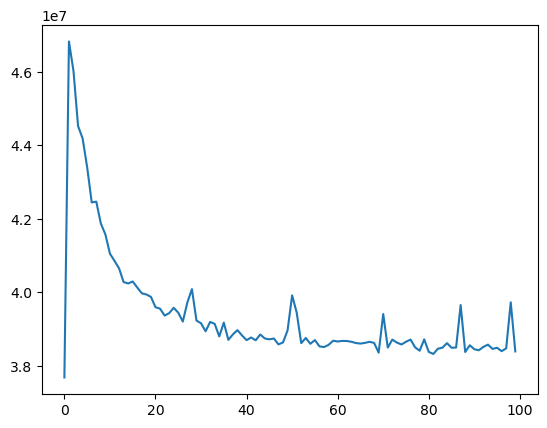

In [17]:
plt.plot(loss_list)

For comaprison, below is the loss plot when using default (larger) values for alpha. Note, that during training alpha is decreasing linearly from start value to end value. With default values in use the loss goes down near the end, once alpha gets smaller values.

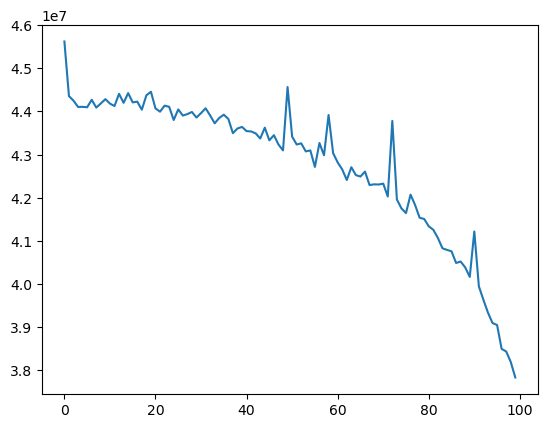

In [18]:
default_alpha_loss_list = [45621836.0, 44355904.0, 44249936.0, 44104492.0, 44107028.0, 44097436.0, 44270596.0, 44089604.0, 44185456.0, 44285424.0, 44182396.0, 44126032.0, 44408908.0, 44199988.0, 44425624.0, 44209516.0, 44227556.0, 44041368.0, 44373620.0, 44456688.0, 44070200.0, 43995008.0, 44134528.0, 44107632.0, 43802268.0, 44047244.0, 43904480.0, 43939264.0, 43987436.0, 43859148.0, 43961468.0, 44073332.0, 43907992.0, 43725336.0, 43849884.0, 43924944.0, 43826232.0, 43496588.0, 43605268.0, 43641544.0, 43543980.0, 43537204.0, 43491140.0, 43373268.0, 43624628.0, 43330720.0, 43449924.0, 43234040.0, 43097712.0, 44565932.0, 43416728.0, 43234072.0, 43260536.0, 43074152.0, 43096868.0, 42714596.0, 43268708.0, 42984456.0, 43917916.0, 43035192.0, 42818392.0, 42656488.0, 42411144.0, 42707748.0, 42523348.0, 42491780.0, 42605616.0, 42294312.0, 42310540.0, 42306532.0, 42327836.0, 42028380.0, 43780020.0, 41960848.0, 41753348.0, 41644528.0, 42072300.0, 41830796.0, 41535968.0, 41507712.0, 41336916.0, 41256888.0, 41069008.0, 40828812.0, 40791320.0, 40758012.0, 40487952.0, 40521400.0, 40385292.0, 40164828.0, 41217672.0, 39945608.0, 39633816.0, 39335348.0, 39096012.0, 39050096.0, 38497092.0, 38436708.0, 38193532.0, 37834140.0]
plt.plot(default_alpha_loss_list)

In [19]:
model.wv.most_similar('сабака', topn=20)

[('кошка', 0.8682211637496948),
 ('котка', 0.8644775748252869),
 ('жывёліна', 0.8603729605674744),
 ('кот', 0.8575648665428162),
 ('кацяня', 0.8407812118530273),
 ('дзік', 0.8391797542572021),
 ('конь', 0.8259259462356567),
 ('пацук', 0.8205081820487976),
 ('сабачка', 0.8192765116691589),
 ('воўк', 0.8112694621086121),
 ('муха', 0.8064222931861877),
 ('авечка', 0.8052395582199097),
 ('шчанюк', 0.8034665584564209),
 ('малпа', 0.7998183965682983),
 ('звер', 0.7971243262290955),
 ('лісіца', 0.7915029525756836),
 ('асёл', 0.7902921438217163),
 ('зграя', 0.7896773219108582),
 ('мядзведзь', 0.7882097363471985),
 ('каза', 0.7871083617210388)]

In [20]:
model.wv.index_to_key[:100]

['быць',
 'год',
 'беларускі',
 'беларусь',
 'чалавек',
 'магчы',
 'час',
 'усё',
 'дзень',
 'большыць',
 'мова',
 'перці',
 'новы',
 'мець',
 'буда',
 'вялікі',
 'краіна',
 'жыццё',
 'раз',
 'праца',
 'быль',
 'месца',
 'адзін',
 'горад',
 'справа',
 'рэспубліка',
 'гісторыя',
 'трэба',
 'яўляцца',
 'тут',
 'свет',
 'слова',
 'кожны',
 'дзіцё',
 'дзяржаўны',
 'нацыянальны',
 'працаваць',
 'пытанне',
 'раён',
 'галоўны',
 'імя',
 'культура',
 'сайт',
 'казаць',
 'гульня',
 'кніга',
 'розны',
 'атрымаць',
 'другі',
 'арганізацыя',
 'школа',
 'апошні',
 'старонка',
 'адбыцца',
 'улада',
 'зрабіць',
 'цэнтр',
 'ведаць',
 'матэрыял',
 'мінск',
 'вынік',
 'дом',
 'хацець',
 'мяць',
 'правіць',
 'рабіць',
 'права',
 'праект',
 'беларус',
 'умова',
 'адукацыя',
 'частка',
 'вайна',
 'праграма',
 'дзяржава',
 'міжнародны',
 'зямля',
 'шмат',
 'развіццё',
 'удзел',
 'жыць',
 'гад',
 'каль',
 'работа',
 'інфармацыя',
 'выбар',
 'народны',
 'наступны',
 'палітычны',
 'праблема',
 'народ',
 'кіраў

In [21]:
# tsne for visualization
# plotly for interactivity https://towardsdatascience.com/how-to-train-a-word2vec-model-from-scratch-with-gensim-c457d587e031
# save filtered out wods into separat file to verify
# dont explicitly list stop words
# prepare assessment data (50 words with 10 most similar wods for them)
# remove words after training
# increase corpus
# increase dimensionality
# merge е/ё , e.g. пачуцце/пачуццё
# п'еса is split to 'п' і 'еса'

In [22]:
model.save("word2vec-100-bel-cc100.model")

INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'word2vec-100-bel-cc100.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-12T15:01:17.893336', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved word2vec-100-bel-cc100.model


In [23]:
model.wv.save_word2vec_format('word2vec-100-bel-cc100.vectors')

INFO:gensim.models.keyedvectors:storing 78886x100 projection weights into word2vec-100-bel-cc100.vectors
